In [3]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns',50)
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.ticker as mtick
import matplotlib.patches as mpatches

from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline, Pipeline
from imblearn.under_sampling import NearMiss

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (accuracy_score, classification_report, f1_score,
                             precision_recall_curve, precision_score,
                             recall_score, roc_auc_score, roc_curve, RocCurveDisplay)
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     ShuffleSplit, StratifiedKFold,
                                     StratifiedShuffleSplit, cross_val_predict,
                                     cross_val_score, learning_curve,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler,OneHotEncoder, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
import os

Importing Dataset

In [4]:
data = pd.read_csv('BankCustomerChurn_Dataset.csv')

In [5]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [7]:
data.shape

(10000, 14)

In [8]:
data.isnull().sum().sum()

np.int64(0)

In [9]:
data.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace = True)

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


In [11]:
data.describe(exclude='number')

,Geography,Gender
count,10000,10000
unique,3,2
top,France,Male
freq,5014,5457


**Exploratory** **Data** **Analysis**

In [12]:
def age_group(age):
  if age <= 30:
    return 'age_group(18-30)'
  elif ((age>30) & (age <=45)):
    return 'age_group(31-45)'
  elif  ((age> 45) & (age <=60)):
    return 'age_group(46-60)'
  elif ((age >61) & (age<=75)):
    return 'age_group (61-75)'
  else:
    return 'age_group(75+)'

In [13]:
def active(cust):
  if cust ==0:
    return 'Inactive'
  else:
    return 'Active'

In [14]:
data['age_group'] = data.Age.apply(age_group)
data['active_mem'] = data.IsActiveMember.apply(active)

In [15]:
gender_churn = data.groupby(['Gender', 'Exited']).size().reset_index(name='count')
gender_per_churn = gender_churn.groupby('Gender').apply(
    lambda x: x.assign(Percent=(x['count'] / x['count'].sum()) * 100)
).reset_index(drop=True)

country_churn = data.groupby(['Geography', 'Exited']).size().reset_index(name='count')
country_per_churn = country_churn.groupby('Geography').apply(
    lambda x: x.assign(Percent=(x['count'] / x['count'].sum()) * 100)
).reset_index(drop=True)


gender_churn = data.groupby(['Gender', 'Exited']).size().reset_index(name='count')
gender_per_churn = gender_churn.groupby('Gender').apply(
    lambda x: x.assign(Percent=(x['count'] / x['count'].sum()) * 100)
).reset_index(drop=True)


In [16]:
country_churn = data.groupby(['Geography', 'Exited']).size().reset_index(name='count')
country_per_churn = country_churn.groupby('Geography').apply(
    lambda x: x.assign(Percent=(x['count'] / x['count'].sum()) * 100)
).reset_index(drop=True)
product_churn = data.groupby(['NumOfProducts', 'Exited']).size().reset_index(name='count')
product_per_churn = product_churn.groupby('NumOfProducts').apply(
    lambda x: x.assign(Percent=(x['count'] / x['count'].sum()) * 100)
).reset_index(drop=True)


tenure_churn = data.groupby(['Tenure', 'Exited']).size().reset_index(name='count')
tenure_per_churn = tenure_churn.groupby('Tenure').apply(
    lambda x: x.assign(Percent=(x['count'] / x['count'].sum()) * 100)
).reset_index(drop=True)



In [17]:
balance_churn = data.groupby(['Balance', 'Exited']).size().reset_index(name='count')
balance_churn_per = balance_churn.groupby(level=[0]).apply(lambda  x: x.assign(Percent=(x['count'] / x['count'].sum()) * 100)
).reset_index(drop=True)


In [18]:
cust_age = data.groupby(['age_group', 'Exited']).size().reset_index(name='count')
cust_age_per = cust_age.groupby(level=[0]).apply(lambda  x: x.assign(Percent=(x['count'] / x['count'].sum()) * 100)
).reset_index(drop=True)


In [19]:
active_member = data.groupby(['active_mem', 'Exited']).size().reset_index(name='count')
active_member_per = active_member.groupby(level=[0]).apply(lambda  x: x.assign(Percent=(x['count'] / x['count'].sum()) * 100)
).reset_index(drop=True)

In [20]:
churn_rate = (data['Exited'].sum()*100/len(data))



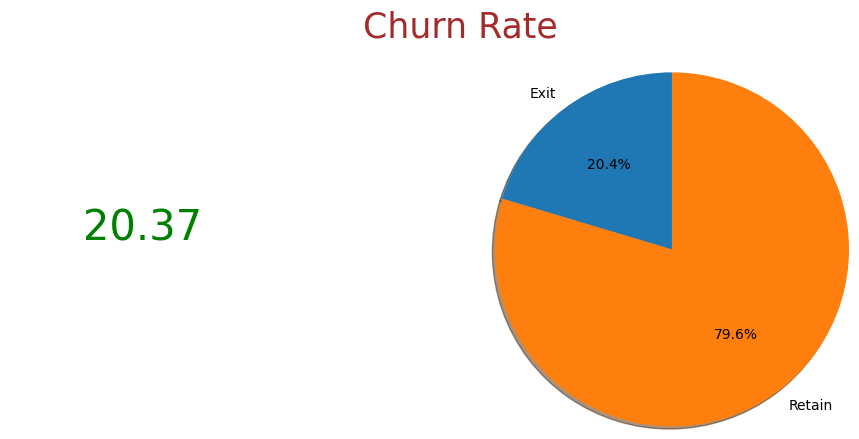

In [21]:
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
value = churn_rate

ax1.text(0.5, 0.5, f"{value:,}", fontsize=30, ha="center", va="bottom",color = 'green')
ax1.axis('off')

sizes = [data.Exited[data['Exited']== 1].count(), data.Exited[data['Exited']==0].count()]
ax2.pie(sizes,labels=['Exit','Retain'],autopct='%1.1f%%',shadow=True, startangle=90,radius=2.0)

plt.tight_layout(pad=3.6,w_pad=6.0,h_pad=5.0,)
plt.subplots_adjust(wspace=1.0)
fig.suptitle('Churn Rate',fontsize=25,color='brown')

plt.show()

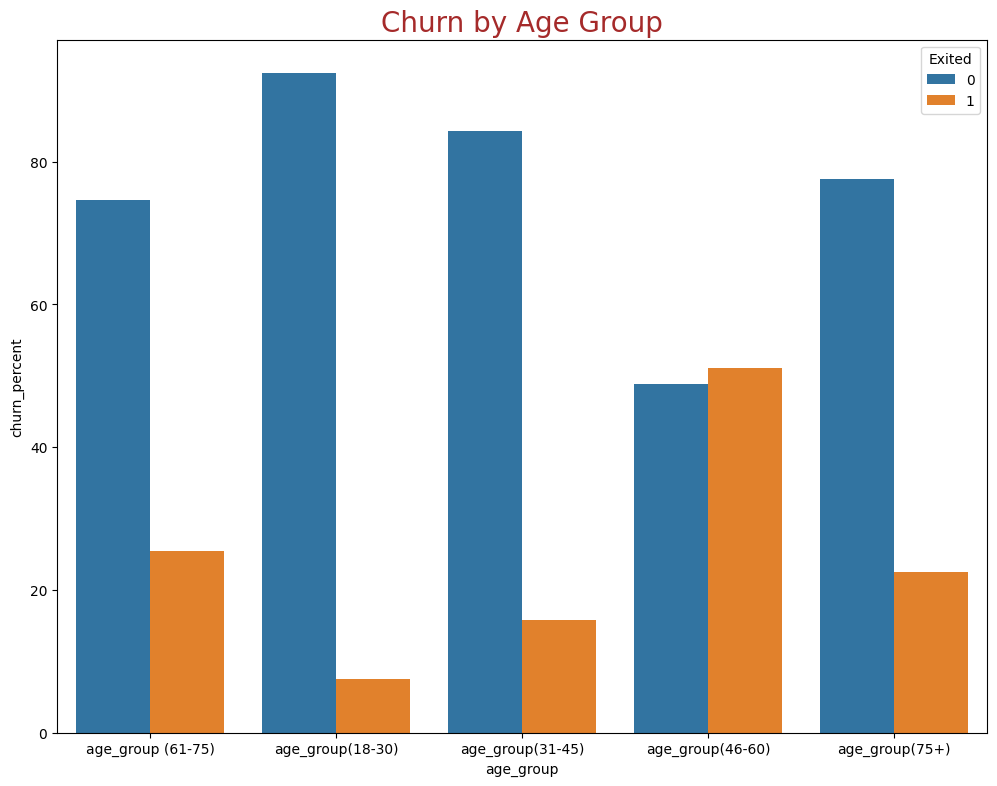

In [22]:
churn_perc = data.groupby(['age_group', 'Exited']).size().reset_index(name='count')
total = data.groupby('age_group').size().reset_index(name='total')
churn_perc = churn_perc.merge(total, on='age_group')
churn_perc['churn_percent'] = (churn_perc['count'] / churn_perc['total']) * 100


plt.figure(figsize=(12,9))
sns.barplot(data=churn_perc,x='age_group',y='churn_percent',hue='Exited')
plt.title('Churn by Age Group',fontsize=20,color='brown')
plt.show()

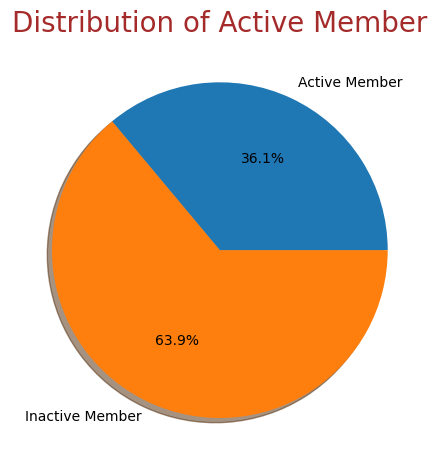

In [23]:
active_churn = data[(data['active_mem']=='Active') & (data['Exited']==1)].shape[0]
inactive_churn = data[(data['active_mem']=='Inactive') & (data['Exited']==1)].shape[0]
cust = [active_churn,inactive_churn]


plt.pie(cust,labels=['Active Member','Inactive Member'],autopct='%1.1f%%',shadow=True,radius=1.0,center=(0,1))
plt.title('Distribution of Active Member',fontsize=20,color='brown')
plt.tight_layout()

In [24]:
credit_churn = data[(data['HasCrCard']==1) & (data['Exited']==1)].shape[0]
non_cred_churn = data[(data['HasCrCard']==0) & (data['Exited']==1)].shape[0]

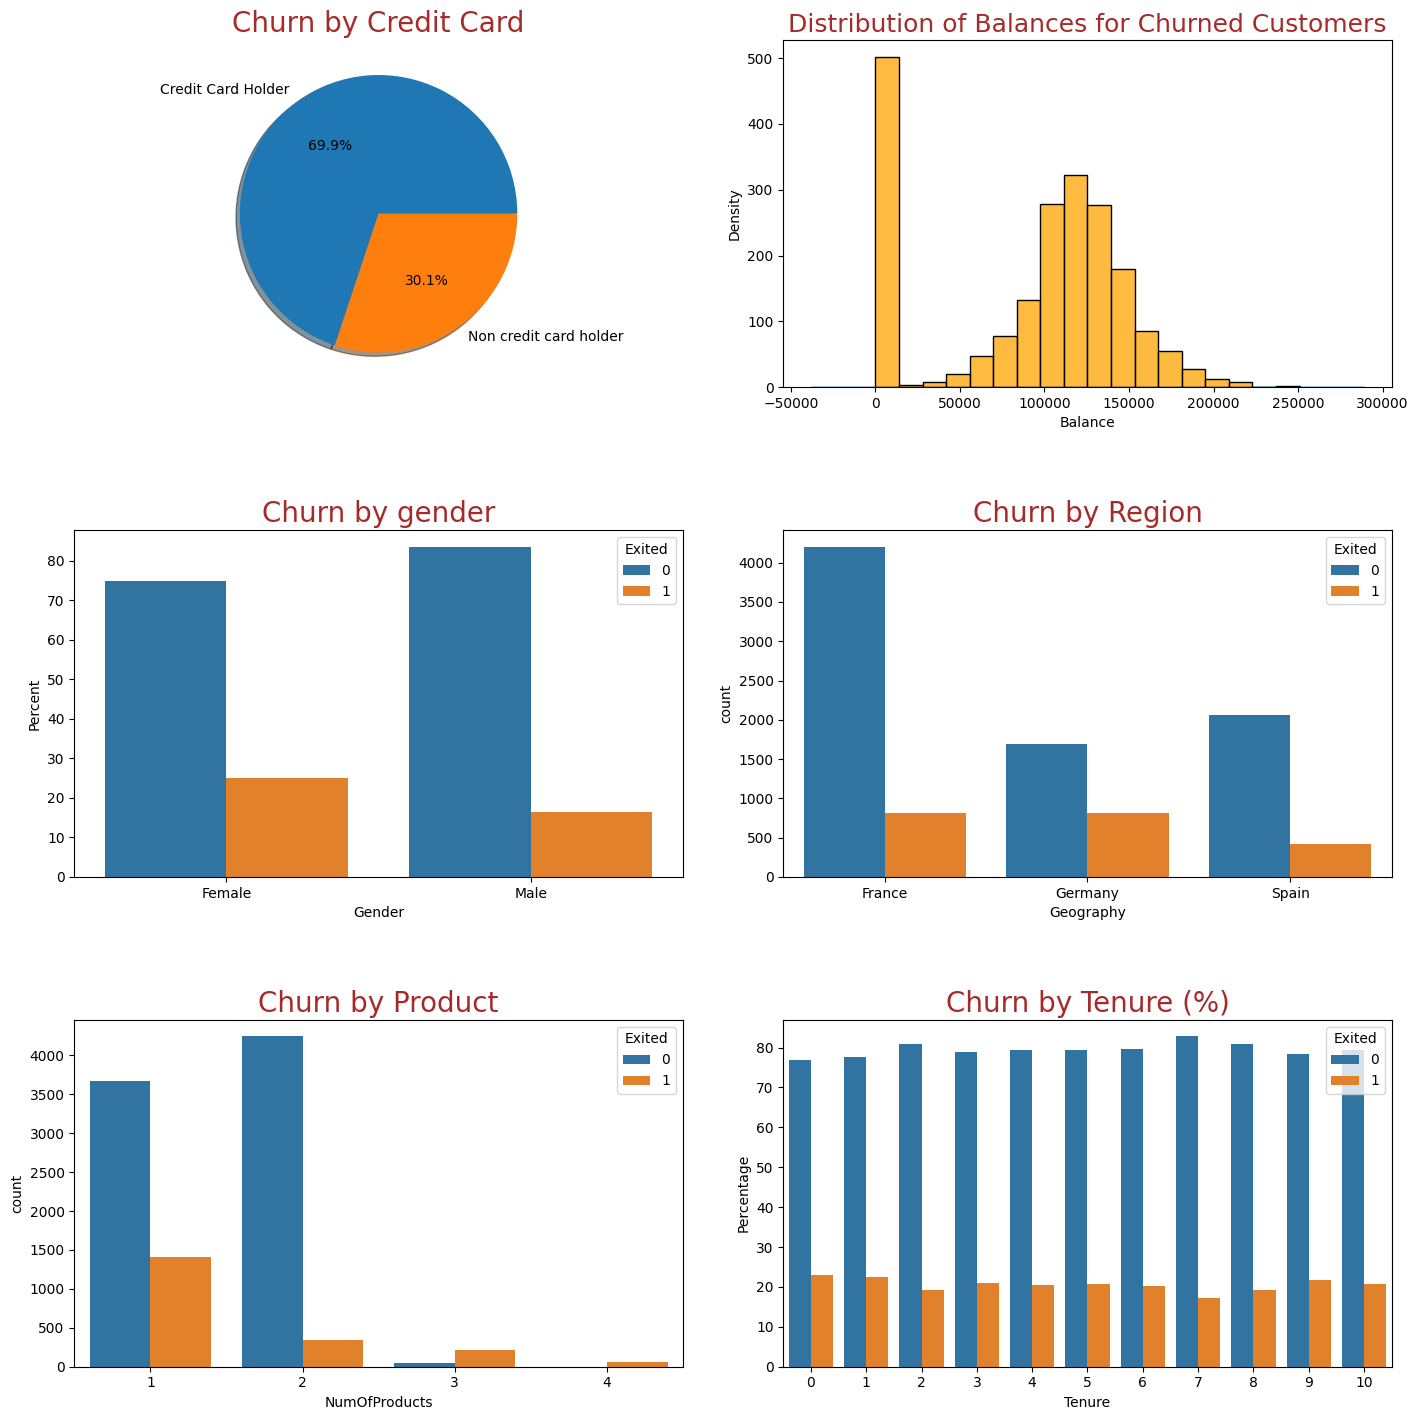

In [25]:
fig,axes = plt.subplots(nrows=3,ncols=2,sharex=False,sharey=False,figsize=(15,15))


size = [credit_churn,non_cred_churn]
axes[0,0].pie(size,labels=['Credit Card Holder','Non credit card holder'],autopct='%1.1f%%',shadow=True,radius=1.0)
axes[0,0].set_title('Churn by Credit Card',fontsize = 20,color='brown')

churned_balances = data.loc[data['Exited'] == 1, 'Balance']

# Plot the histogram
sns.kdeplot(churned_balances, shade=True,ax=axes[0,1])
sns.histplot(churned_balances, kde=False, color="orange",ax=axes[0,1])
axes[0,1].set_title("Distribution of Balances for Churned Customers",color='brown',fontsize=18)
axes[0,1].set_xlabel("Balance")
axes[0,1].set_ylabel("Density")


sns.barplot(data=gender_per_churn,x='Gender',y='Percent',hue='Exited',ax=axes[1,0])
axes[1,0].set_title('Churn by gender',fontsize = 20,color='brown')

sns.barplot(data=country_churn,x='Geography',y='count',hue='Exited',ax=axes[1,1])
axes[1,1].set_title('Churn by Region',fontsize = 20,color='brown')

sns.barplot(data=product_churn,x='NumOfProducts',y='count',hue='Exited',ax=axes[2,0])
axes[2,0].set_title('Churn by Product',fontsize = 20,color='brown')

sns.barplot(data=tenure_per_churn, x='Tenure', y='Percent', hue='Exited', ax=axes[2,1])
axes[2,1].set_title('Churn by Tenure (%)', fontsize=20, color='brown')
axes[2,1].set_ylabel("Percentage")


plt.tight_layout(pad=3.6,w_pad=2.6,h_pad=5.0,)
plt.show()

In [26]:
numeric_data = data.select_dtypes(include=[np.number])
numeric_data.columns
corr_val = np.abs(numeric_data.corrwith(data['Exited']))
corr_val

,0
CreditScore,0.027094
Age,0.285323
Tenure,0.014001
Balance,0.118533
NumOfProducts,0.047820
HasCrCard,0.007138
IsActiveMember,0.156128
EstimatedSalary,0.012097
Exited,1.000000


**ENCODING CATEGORICAL VARIABLES**

In [27]:
data = pd.get_dummies(data,drop_first=True)


pd.get_dummies(): This function is used to convert
categorical variables into dummy/indicator variables.

drop_first=True: This parameter is used to avoid the dummy variable trap by dropping the first level of each categorical feature.

Dummy Variable Trap
The dummy variable trap occurs when the dummy variables created are highly correlated, leading to multicollinearity issues in models such as linear regression. This can result in redundant data and affect the performance of the model. To avoid this, one level of each categorical feature is dropped.

In [28]:
data

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,age_group_age_group(18-30),age_group_age_group(31-45),age_group_age_group(46-60),age_group_age_group(75+),active_mem_Inactive
0,619,42,2,0.00,1,1,1,101348.88,1,False,False,False,False,True,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False,False,True,False,False,False
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False,False,True,False,False,True
3,699,39,1,0.00,2,0,0,93826.63,0,False,False,False,False,True,False,False,True
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,False,False,True,False,True,False,False,True
9996,516,35,10,57369.61,1,1,1,101699.77,0,False,False,True,False,True,False,False,False
9997,709,36,7,0.00,1,0,1,42085.58,1,False,False,False,False,True,False,False,False
9998,772,42,3,75075.31,2,1,0,92888.52,1,True,False,True,False,True,False,False,True


In [29]:
all_columns = data.columns.tolist()

In [30]:
cols_to_drop = [col for col in data.columns if 'age_group_age_group' in col and '(' in col]
cols_to_drop.append('active_mem_Inactive')
print(cols_to_drop)
data.drop(columns=cols_to_drop, inplace=True)

['age_group_age_group(18-30)', 'age_group_age_group(31-45)', 'age_group_age_group(46-60)', 'age_group_age_group(75+)', 'active_mem_Inactive']


In [31]:
data

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,False,False,True
9996,516,35,10,57369.61,1,1,1,101699.77,0,False,False,True
9997,709,36,7,0.00,1,0,1,42085.58,1,False,False,False
9998,772,42,3,75075.31,2,1,0,92888.52,1,True,False,True


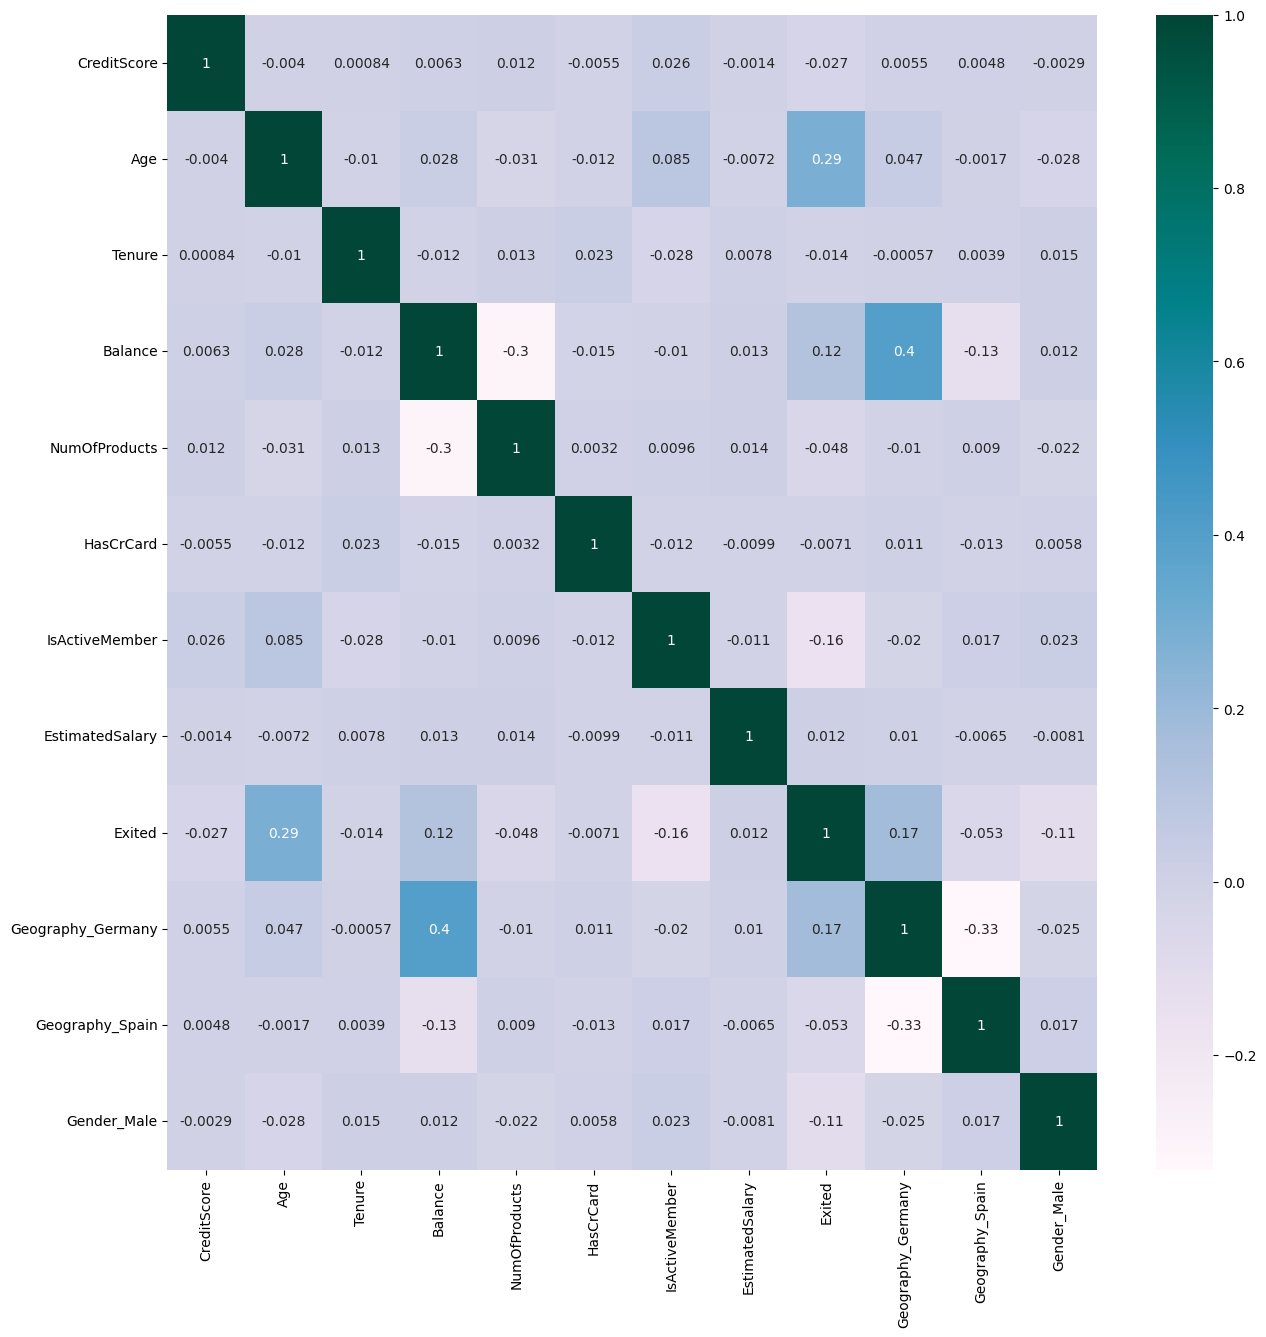

In [32]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(),annot=True,cmap="PuBuGn")

plt.show()

**Splitting the dataset into Features (x) and Target (y)**

In [33]:
x= data[data.columns.difference(['Exited'])]
y = data['Exited']

In [34]:
print('shape of x:',x.shape)
print('shape of y:',y.shape)

shape of x: (10000, 11)
shape of y: (10000,)


**Splitting into Testing and Training datasets**

In [35]:
train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.3,random_state=123)

In [36]:
print('shape of train_x:',train_x.shape)
print('shape of train_y:',train_y.shape)
print('shape of test_x:',test_x.shape)
print('shape of test_y:',test_y.shape)

shape of train_x: (7000, 11)
shape of train_y: (7000,)
shape of test_x: (3000, 11)
shape of test_y: (3000,)


**Resampling**

Since, over 80% of the data points belong to the majority class, "Stays" (0), while only 20% belong to the minority class, "Exits" (1), this creates an imbalanced dataset. Therefore, we will use SMOTE method to create a balanced dataset.

In [37]:
x_res,y_res = SMOTE().fit_resample(x,y)

In [38]:
y_res.value_counts()

,count
Exited,
1,7963
0,7963




*   x_res: The resampled feature matrix is now balanced.
*   y_res: The resampled target vector,has an equal or more balanced distribution of classes.

*   The class distribution is now more balanced, which can help improve the performance of machine learning models by providing a more equal representation of each class during training.








In [39]:
x_res

,Age,Balance,CreditScore,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain,HasCrCard,IsActiveMember,NumOfProducts,Tenure
0,42,0.000000,619,101348.880000,False,False,False,1,1,1,2
1,41,83807.860000,608,112542.580000,False,False,True,0,1,1,1
2,42,159660.800000,502,113931.570000,False,False,False,1,0,3,8
3,39,0.000000,699,93826.630000,False,False,False,0,0,2,1
4,43,125510.820000,850,79084.100000,False,False,True,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
15921,43,0.000000,692,174073.781067,True,False,True,0,0,1,2
15922,32,57914.535931,676,182121.217779,True,False,True,1,0,1,2
15923,47,138049.251713,719,3503.920570,False,True,True,1,0,1,9
15924,47,107544.574438,572,109096.277162,True,True,False,0,0,1,3


In [40]:
train_x,test_x,train_y,test_y = train_test_split(x_res,y_res,test_size=0.3,random_state=123)
print('shape of train_x:',train_x.shape)
print('shape of train_y:',train_y.shape)

shape of train_x: (11148, 11)
shape of train_y: (11148,)


In [41]:
test_x

,Age,Balance,CreditScore,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain,HasCrCard,IsActiveMember,NumOfProducts,Tenure
8117,34,0.00,624,582.590000,False,False,True,1,0,1,6
8265,40,140306.38,618,160618.610000,False,True,False,1,0,1,0
5455,45,116585.97,805,189428.750000,False,True,False,1,0,1,9
10787,50,0.00,513,156843.963457,False,False,False,0,0,1,6
337,33,0.00,649,2010.980000,True,False,False,1,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...
6625,41,112119.48,657,17536.820000,False,False,True,1,0,1,6
9921,36,65349.71,757,64539.640000,True,True,False,0,0,1,1
2141,18,0.00,674,55753.120000,True,False,False,1,1,2,7
3214,33,68193.72,572,19998.310000,True,False,False,1,0,1,9


**Feature scaling**

In [42]:
sc=StandardScaler()
st= sc.fit(train_x)
train_x_std = pd.DataFrame(st.transform(train_x),columns=train_x.columns)
test_x_std = pd.DataFrame(st.transform(test_x),columns=test_x.columns)
test_x_std

,Age,Balance,CreditScore,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain,HasCrCard,IsActiveMember,NumOfProducts,Tenure
0,-0.696332,-1.347402,-0.271968,-1.717326,-1.223418,-0.763003,1.586417,0.774671,-0.761092,-0.730136,0.435805
1,-0.095379,0.944837,-0.337260,1.042383,-1.223418,1.310610,-0.630351,0.774671,-0.761092,-0.730136,-1.766366
2,0.405415,0.557307,1.697685,1.539194,-1.223418,1.310610,-0.630351,0.774671,-0.761092,-0.730136,1.536891
3,0.906209,-1.347402,-1.479876,0.977292,-1.223418,-0.763003,-0.630351,-1.290871,-0.761092,-0.730136,0.435805
4,-0.796490,-1.347402,0.000084,-1.692694,0.817382,-0.763003,-0.630351,0.774671,-0.761092,1.012809,-1.032309
...,...,...,...,...,...,...,...,...,...,...,...
4773,0.004780,0.484337,0.087140,-1.424962,-1.223418,-0.763003,1.586417,0.774671,-0.761092,-0.730136,0.435805
4774,-0.496014,-0.279759,1.175346,-0.614431,0.817382,1.310610,-0.630351,-1.290871,-0.761092,-0.730136,-1.399338
4775,-2.298872,-1.347402,0.272135,-0.765949,0.817382,-0.763003,-0.630351,0.774671,1.313902,1.012809,0.802834
4776,-0.796490,-0.233295,-0.837835,-1.382516,0.817382,-0.763003,-0.630351,0.774671,-0.761092,-0.730136,1.536891


**Model Building**

In [43]:
def metric_table(y_true,y_pred,y_proba,model_name):
    prec = precision_score(y_true,y_pred)
    acc = accuracy_score(y_true,y_pred)
    recall = recall_score(y_true,y_pred)
    f1 = f1_score(y_true,y_pred)
    roc = roc_auc_score(y_true,y_proba[:, 1])
    metric = pd.DataFrame(data={
        "model" : model_name,
        "Precision" : prec,
        "Accuracy" : acc,
        "Recall" : recall,
        "F1-score" : f1,
        "ROC_AUC" : roc
    },index=[0])
    return metric

This function calculates and returns a DataFrame containing various performance metrics for a classification model. These metrics include precision, accuracy, recall, F1-score, and ROC AUC score.

**Parameters:**

y_true: The true labels for the test data.

y_pred: The predicted labels from the model.

y_proba: The predicted probabilities from the model, typically for the positive class.

model_name: A string representing the name of the model being evaluated.

**Metrics:**

precision score, which is the ratio of true positive predictions to the total number of positive predictions (true positives + false positives).

accuracy score, which is the ratio of correctly predicted instances (true positives + true negatives) to the total number of instances.

recall score, which is the ratio of true positive predictions to the total number of actual positives (true positives + false negatives).

F1-score, which is the harmonic mean of precision and recall, providing a balance between the two.

the ROC AUC score, which is the area under the Receiver Operating Characteristic curve. It measures the ability of the model to distinguish between classes. The y_proba[:, 1] selects the probabilities for the positive class.

In [44]:
def roc_curve_plot(Y_pred, Y_true, Y_pred_pobablities, model_name):
    Y_pp = Y_pred_pobablities[:, 1]
    fpr, tpr, threshold1 = roc_curve(Y_true, Y_pp )

    fig, ax = plt.subplots(nrows=1, ncols= 1, figsize = (7,5), constrained_layout = True)
    ax.plot(fpr, tpr, label='ROC Score: {:.5f}'.format(roc_auc_score(Y_true, Y_pp)),color='Red')
    ax.set_title(f"{model_name} ROC Curve ", fontdict = {"fontsize": 18})
    ax.set_xlabel("False Positive Rate", fontdict = {"fontsize": 15} )
    ax.set_ylabel("True Positive Rate", fontdict = {"fontsize": 15})
    ax.legend(loc = 4, fontsize = 14 )

    plt.show()

**Logistic Regression**

In [45]:
import copy
train_x_lr = copy.deepcopy(train_x_std)
test_x_lr = copy.deepcopy(test_x_std)

This code is used to create deep copies of the train_x_std and test_x_std DataFrames. The purpose of deep copying is to create completely independent copies of these DataFrames, so that changes made to the copied DataFrames (train_x_lr and test_x_lr) do not affect the original DataFrames (train_x_std and test_x_std).

In [46]:
lr=LogisticRegression()

lr_model = lr.fit(train_x_lr,train_y)

In [47]:
lr_pred = lr_model.predict(test_x_lr)
lr_prob = lr_model.predict_proba(test_x_lr)

This code is used to get the predicted probabilities for each class from a trained logistic regression model (lr_model) for the test dataset (test_x_lr). The predict_proba method returns the probability estimates for all classes, which can be used to evaluate the model's performance or make decisions based on these probabilities.

In [48]:
metric_table(test_y,lr_pred,lr_prob,'LogisticRegression')

,model,Precision,Accuracy,Recall,F1-score,ROC_AUC
0,LogisticRegression,0.77349,0.776685,0.777731,0.775605,0.854357


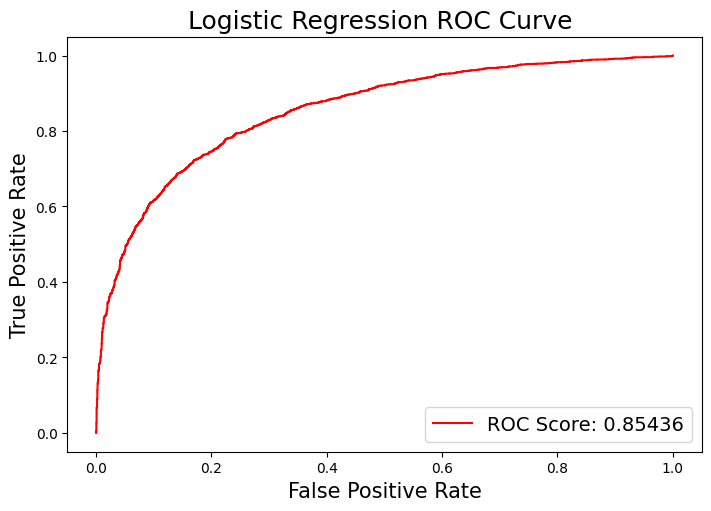

In [49]:
roc_curve_plot(lr_pred,test_y,lr_prob,"Logistic Regression")

**K-Nearest Neighbour**

In [50]:
train_x_knn = copy.deepcopy(train_x_std)
test_x_knn = copy.deepcopy(test_x_std)

In [51]:
knn= KNeighborsClassifier()
knn_model = knn.fit(train_x_knn,train_y)

knn_pred = knn_model.predict(test_x_knn)
knn_prob = knn_model.predict_proba(test_x_knn)

In [52]:
metric_table(test_y,knn_pred,knn_prob,"KNN")

,model,Precision,Accuracy,Recall,F1-score,ROC_AUC
0,KNN,0.814907,0.822101,0.83003,0.822399,0.884572


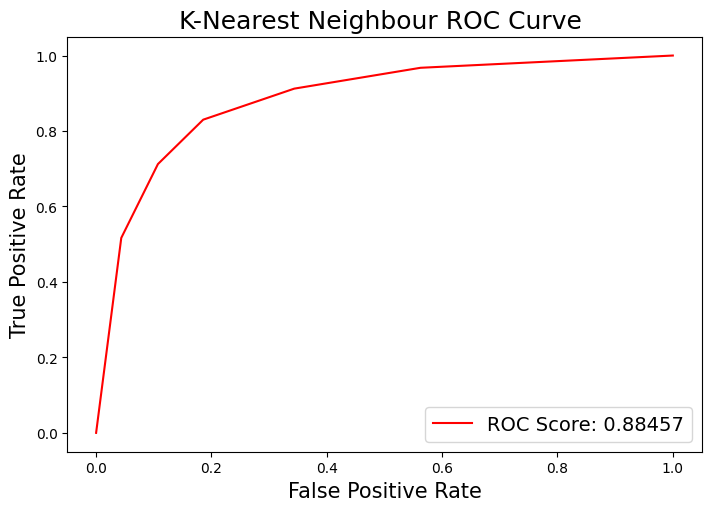

In [53]:
roc_curve_plot(knn_pred,test_y,knn_prob,"K-Nearest Neighbour")

**Decision Tree Classifier**

In [54]:
dt = DecisionTreeClassifier()
dt_model = dt.fit(train_x_std,train_y)

In [55]:
dt_pred = dt_model.predict(test_x_std)
dt_prob = dt_model.predict_proba(test_x_std)

In [56]:
metric_table(test_y,dt_pred,dt_prob,"Decision Tree Classifier")

,model,Precision,Accuracy,Recall,F1-score,ROC_AUC
0,Decision Tree Classifier,0.79129,0.800544,0.812315,0.801665,0.800632


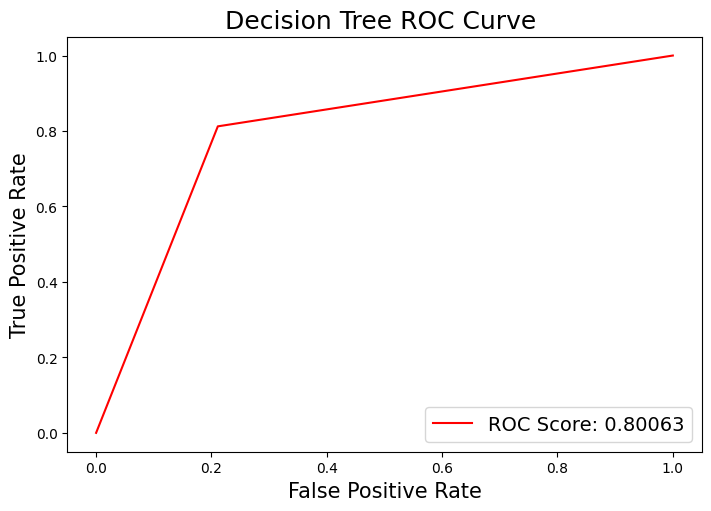

In [57]:
roc_curve_plot(dt_pred,test_y,dt_prob,"Decision Tree")

**Random Forest**

In [58]:
rf = RandomForestClassifier()
rf_model = rf.fit(train_x_std,train_y)

In [59]:
rf_pred= rf_model.predict(test_x_std)
rf_prob = rf_model.predict_proba(test_x_std)

In [60]:
metric_table(rf_pred,test_y,rf_prob,"Random Forest")

,model,Precision,Accuracy,Recall,F1-score,ROC_AUC
0,Random Forest,0.855757,0.863332,0.867094,0.861388,1.0


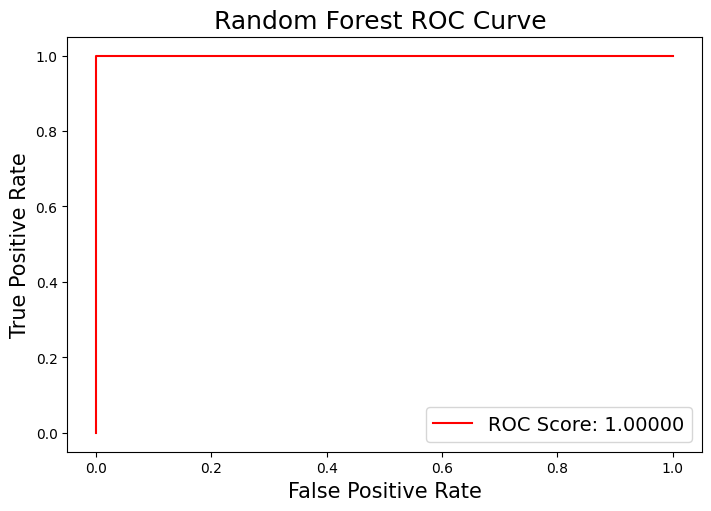

In [61]:
roc_curve_plot(test_y,rf_pred,rf_prob,"Random Forest")

**Gradient Boosting**

In [62]:
gb = GradientBoostingClassifier()
gb_model = gb.fit(train_x_std,train_y)

In [63]:
gb_pred = gb_model.predict(test_x_std)
gb_prob = gb_model.predict_proba(test_x_std)

In [64]:
metric_table(test_y,gb_pred,gb_prob,"Gradient Boosting")

,model,Precision,Accuracy,Recall,F1-score,ROC_AUC
0,Gradient Boosting,0.846321,0.836752,0.819907,0.832905,0.921051


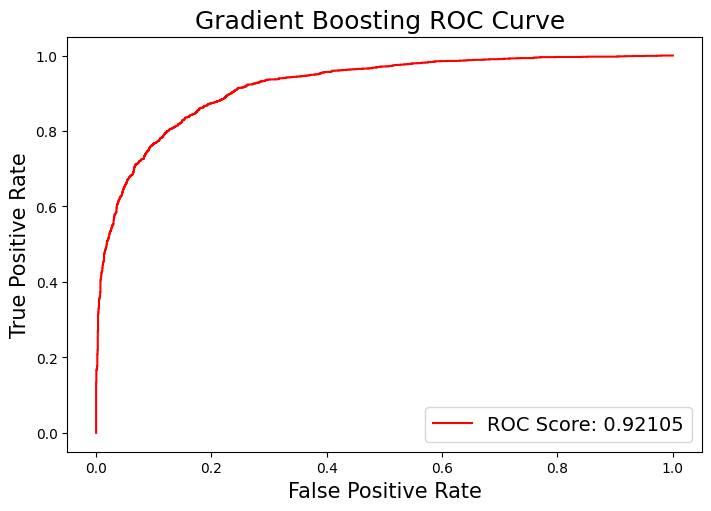

In [65]:
roc_curve_plot(gb_pred,test_y,gb_prob,"Gradient Boosting")

**XGBoost**

In [66]:
xg = XGBClassifier()
xgb_model = xg.fit(train_x_std,train_y)

In [67]:
xgb_pred = xgb_model.predict(test_x_std)
xgb_prob = xgb_model.predict_proba(test_x_std)

In [68]:
metric_table(test_y,xgb_pred,xgb_prob,"XGBoost")

,model,Precision,Accuracy,Recall,F1-score,ROC_AUC
0,XGBoost,0.860366,0.8581,0.852383,0.856356,0.934362


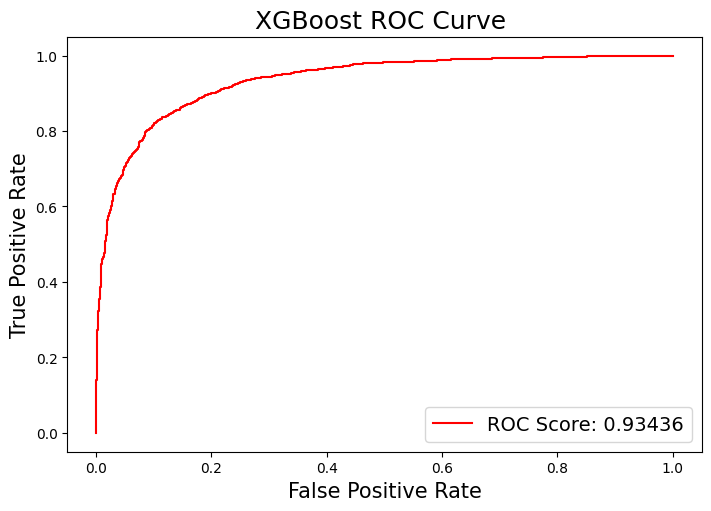

In [69]:
roc_curve_plot(xgb_pred,test_y,xgb_prob,"XGBoost")

In [72]:
def roc_summary_plot(Y_true, Y_probability = [], model_name = []):
    for i in range(len(Y_probability)):

        fpr, tpr, threshold1 = roc_curve(Y_true,Y_probability[i][:,1] )
        plt.style.use('fivethirtyeight')
        plt.figure( num = 1, figsize = (12, 9))
        plt.title("ROC scores summary (tuned model)", fontsize = 18)
        plt.xlabel("False Positive Rate" , fontdict = {"fontsize": 15})
        plt.ylabel("True Positive Rate" , fontdict = {"fontsize": 15})
        plt.plot(fpr, tpr, label='{0} ROC Score: {1}'.format(model_name[i] ,round(roc_auc_score(Y_true, Y_probability[i][:,1] ) ,2)))
        plt.legend(loc = 4, fontsize =13)
    plt.show()

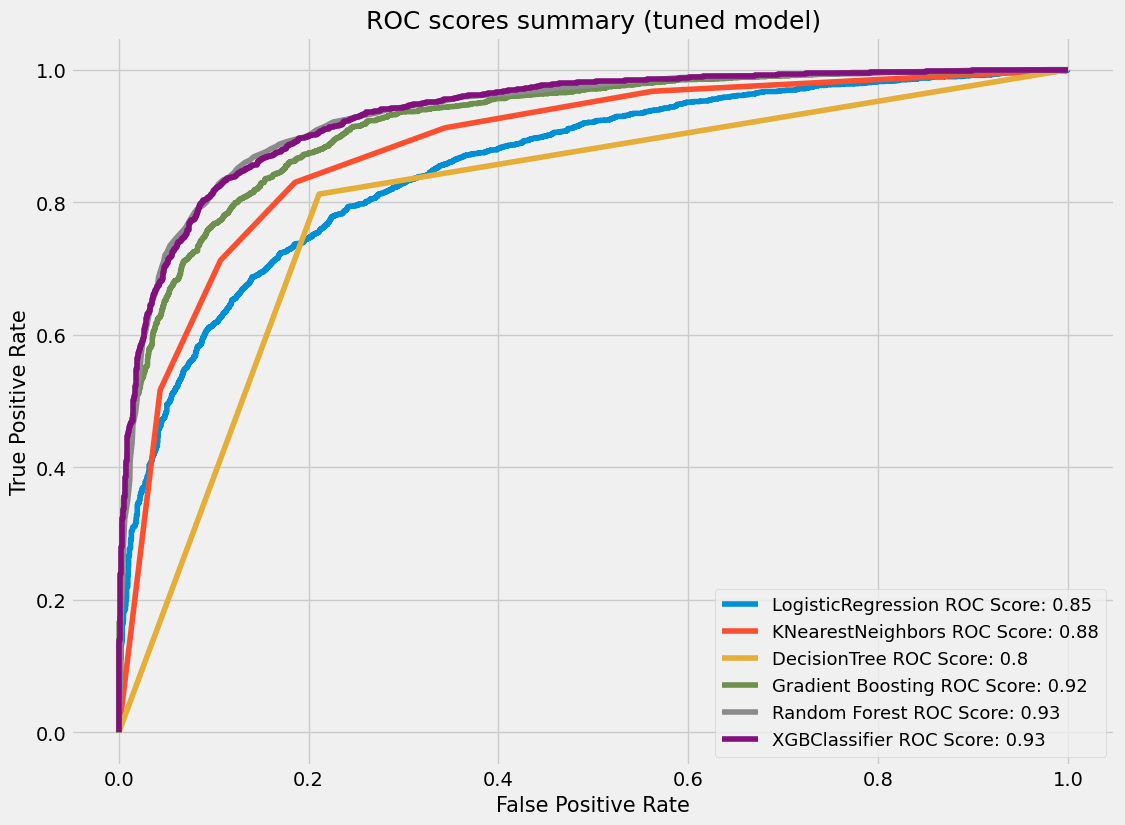

In [73]:
roc_summary_plot(test_y,[lr_prob,knn_prob,dt_prob,gb_prob,rf_prob,xgb_prob],
                 ["LogisticRegression", "KNearestNeighbors", "DecisionTree","Gradient Boosting","Random Forest", "XGBClassifier"])

In [74]:
table_lr = metric_table(test_y,lr_pred,lr_prob,'LogisticRegression')
table_knn = metric_table(test_y,knn_pred,knn_prob,"KNN")
table_dt = metric_table(test_y,dt_pred,dt_prob,"Decision Tree")
table_gb = metric_table(test_y,gb_pred,gb_prob,"Gradient Boosting")
table_rf = metric_table(test_y,knn_pred,knn_prob,"Random Forest")
table_xg = metric_table(test_y,xgb_pred,xgb_prob,"XGBoost")

summary_table = pd.concat([table_lr,table_knn,table_dt,table_gb,table_rf,table_xg])

In [75]:
summary_table

,model,Precision,Accuracy,Recall,F1-score,ROC_AUC
0,LogisticRegression,0.773490,0.776685,0.777731,0.775605,0.854357
0,KNN,0.814907,0.822101,0.830030,0.822399,0.884572
0,Decision Tree,0.791290,0.800544,0.812315,0.801665,0.800632
0,Gradient Boosting,0.846321,0.836752,0.819907,0.832905,0.921051
0,Random Forest,0.814907,0.822101,0.830030,0.822399,0.884572
0,XGBoost,0.860366,0.858100,0.852383,0.856356,0.934362


**Feature Importance**

In [76]:
print(rf.feature_importances_)

[0.22124529 0.13461241 0.11139499 0.116675   0.01605288 0.06924563
 0.02159865 0.02033821 0.11105367 0.1077766  0.07000667]


**The rf.feature_importances_ attribute provides the importance scores for each feature in a trained Random Forest model. These scores indicate how much each feature contributes to the model's predictions, allowing you to understand which features are most influential.**

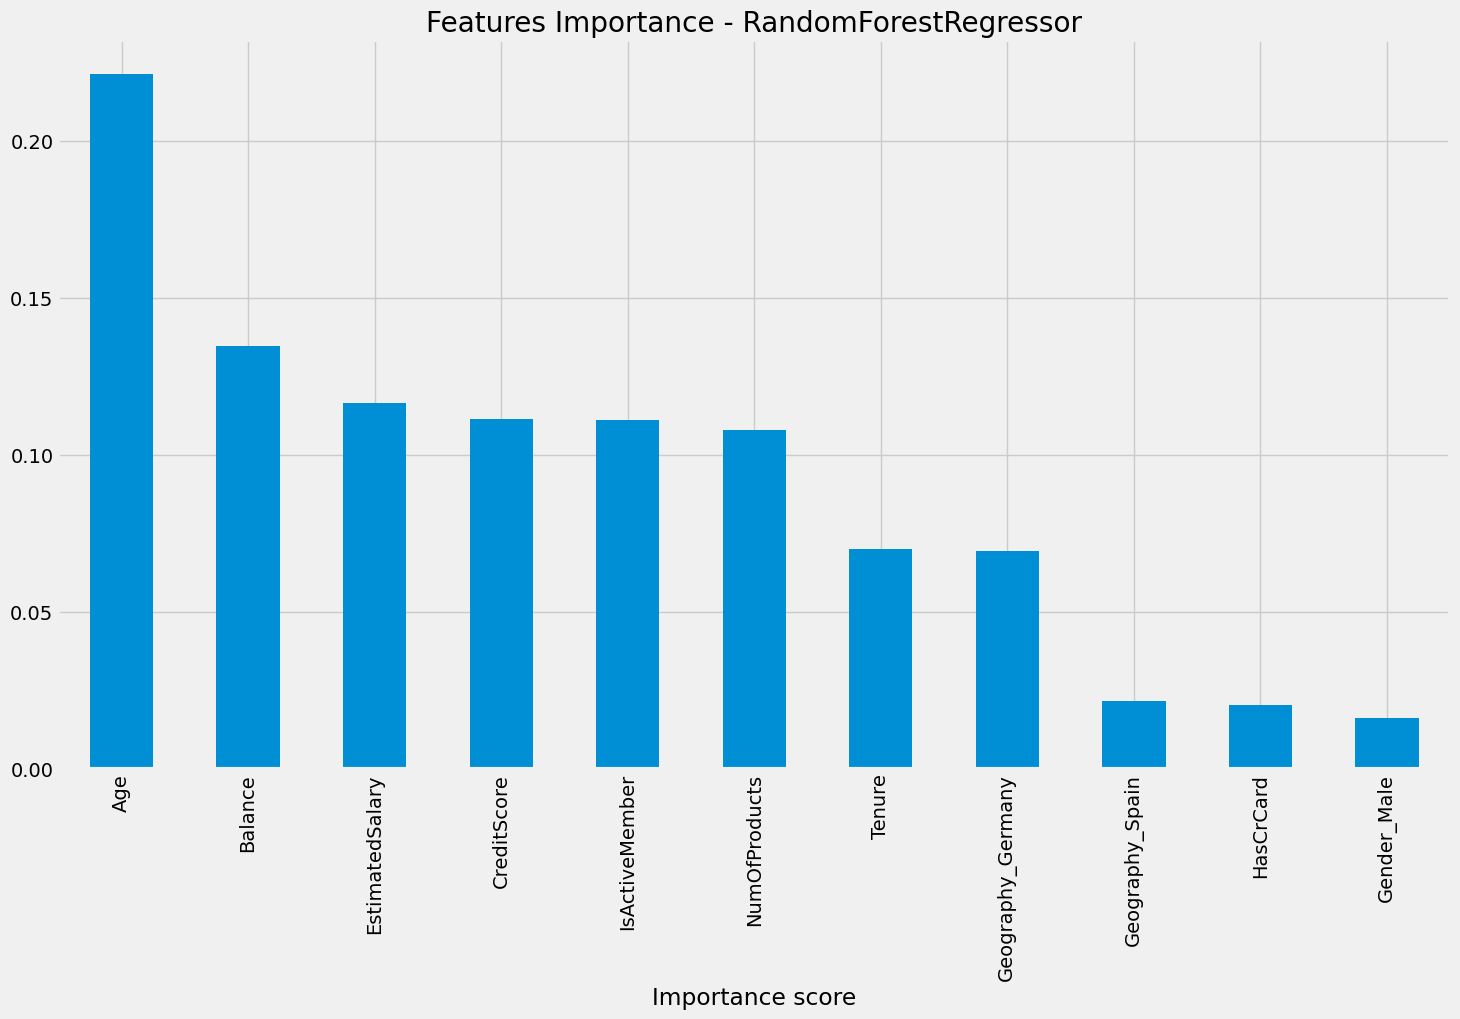

In [77]:
feat_importances = pd.Series(rf.feature_importances_, index=x.columns)
plt.figure(figsize=(16, 9))
feat_importances.nlargest(len(rf.feature_importances_)).plot(kind='bar')
plt.xlabel('Importance score')
plt.title('Features Importance - RandomForestRegressor')
plt.show()

In [78]:
final_df =  feat_importances.nlargest(len(rf.feature_importances_)).index[:8]
final_df

Index(['Age', 'Balance', 'EstimatedSalary', 'CreditScore', 'IsActiveMember',
       'NumOfProducts', 'Tenure', 'Geography_Germany'],
      dtype='object')

In [79]:
train_x

,Age,Balance,CreditScore,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain,HasCrCard,IsActiveMember,NumOfProducts,Tenure
3055,44,115049.150000,812,165038.410000,True,False,False,1,0,2,4
6982,50,0.000000,753,861.400000,False,False,False,1,1,2,4
1853,41,167545.320000,730,128246.810000,False,False,False,1,0,1,4
11276,21,0.000000,654,55776.466537,True,False,False,1,1,1,7
9358,29,0.000000,837,41866.260000,False,False,False,1,1,2,9
...,...,...,...,...,...,...,...,...,...,...,...
12252,57,185518.148074,580,9832.401692,True,False,True,0,0,1,9
1346,30,94443.770000,643,165614.400000,True,False,False,1,1,1,5
11646,42,105358.462809,592,192181.077006,False,True,False,0,0,1,7
15725,51,117297.517500,552,54079.547974,True,True,False,0,0,2,4


In [80]:
cv = StratifiedKFold(n_splits=5,random_state=123,shuffle=True)

This code sets up a cross-validation strategy using StratifiedKFold from the sklearn.model_selection module. It creates a cross-validator object that can be used to split data into training and validation sets in a stratified manner, ensuring that each fold has the same proportion of each class.

**Hyperparameter Tuning**

In [81]:
param_grid = {'n_estimators':np.arange(2,50,2),'max_depth':np.arange(2,50,2)}
grid =GridSearchCV(RandomForestClassifier(),param_grid=param_grid,n_jobs=-1,cv=5,scoring='roc_auc',verbose=True)
grid.fit(train_x_std[final_df],train_y)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48]),
                         'n_estimators': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48])},
             scoring='roc_auc', verbose=True)

In [82]:
grid.best_params_

{'max_depth': np.int64(40), 'n_estimators': np.int64(48)}

**The code grid.best_params_ is used to retrieve the best combination of hyperparameters found during the grid search.**

In [83]:
test_x[final_df]

,Age,Balance,EstimatedSalary,CreditScore,IsActiveMember,NumOfProducts,Tenure,Geography_Germany
8117,34,0.00,582.590000,624,0,1,6,False
8265,40,140306.38,160618.610000,618,0,1,0,True
5455,45,116585.97,189428.750000,805,0,1,9,True
10787,50,0.00,156843.963457,513,0,1,6,False
337,33,0.00,2010.980000,649,0,2,2,False
...,...,...,...,...,...,...,...,...
6625,41,112119.48,17536.820000,657,0,1,6,False
9921,36,65349.71,64539.640000,757,0,1,1,True
2141,18,0.00,55753.120000,674,1,2,7,False
3214,33,68193.72,19998.310000,572,0,1,9,False


In [84]:
rf = RandomForestClassifier(n_estimators=48,max_depth=42)

In [85]:
rf = rf.fit(train_x_std[final_df],train_y)
new_pred = rf.predict(test_x_std[final_df])
new_prob = rf.predict_proba(test_x_std[final_df])
metric_table(test_y,new_pred,new_prob,"Random Forest")

,model,Precision,Accuracy,Recall,F1-score,ROC_AUC
0,Random Forest,0.861063,0.856216,0.8469,0.853923,0.92429


In [86]:
XGB_parameters = {
    'n_estimators': [100, 400],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.20],
    'min_child_weight': [1, 10]}

grid_xg = GridSearchCV(estimator=XGBClassifier(),param_grid=XGB_parameters,cv=5,scoring='roc_auc',verbose=True)

This code is designed to find the optimal hyperparameters for an XGBoost classifier by performing a grid search with cross-validation. The goal is to identify the best combination of n_estimators, max_depth, learning_rate, and min_child_weight that maximizes the model's performance as measured by the ROC AUC score.

In [87]:
grid_xg = grid_xg.fit(train_x_std[final_df],train_y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [88]:
grid_xg.best_params_

{'learning_rate': 0.2,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 400}

In [89]:
best_XGB = grid_xg.best_estimator_
best_XGB.fit(train_x[final_df], train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

This code snippet is used to extract the best estimator (i.e., the model with the best combination of hyperparameters found during the grid search) and then fit this best model to the training data.By extracting and fitting the best estimator, you leverage the hyperparameter tuning results to build a highly effective predictive model.

In [90]:
xg_pred_new =  best_XGB.predict(test_x[final_df])
xg_prob_new = best_XGB.predict_proba(test_x[final_df])

In [91]:
metric_table(test_y,xg_pred_new,xg_prob_new,"XGBoost")

,model,Precision,Accuracy,Recall,F1-score,ROC_AUC
0,XGBoost,0.858475,0.85789,0.854492,0.856479,0.932712


In [92]:
grid_xg.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [93]:
score_1 = metric_table(test_y,new_pred,new_prob,"Random Forest")
score_2 = metric_table(test_y,xg_pred_new,xg_prob_new,"XGBoost")
score = pd.concat([score_1,score_2])

In [94]:
score

,model,Precision,Accuracy,Recall,F1-score,ROC_AUC
0,Random Forest,0.861063,0.856216,0.846900,0.853923,0.924290
0,XGBoost,0.858475,0.857890,0.854492,0.856479,0.932712


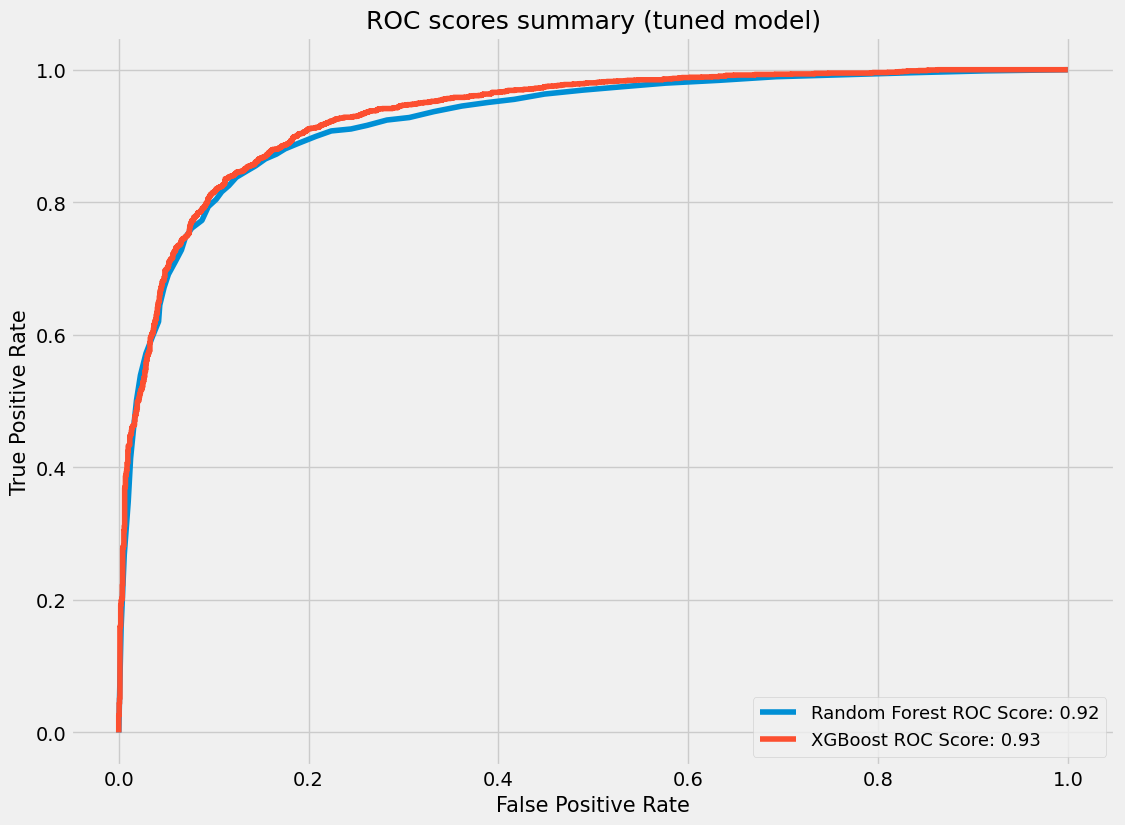

In [95]:
roc_summary_plot(test_y,[new_prob,xg_prob_new],['Random Forest','XGBoost'])